In [42]:
%load_ext autoreload
%autoreload 2

import joblib
import os
from sklearn.model_selection import train_test_split
from FaceBinaryDataset import FaceBinaryDataset
from build_pipeline import build_pipeline
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
import numpy as np
from sklearn.metrics import precision_score, recall_score
import time
import pandas as pd
import cv2
from PIL import ImageEnhance
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
dataset = FaceBinaryDataset("dataset/output_dataset", dimension=160)

images = []
labels = []

for i in range(len(dataset)):
    img, label, userid = dataset[i]

    if img is None:
        continue

    images.append(img)
    labels.append(label)

X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

No face detected in: dataset/output_dataset\authorized\user_00001\img_005.jpg
No face detected in: dataset/output_dataset\authorized\user_00001\img_007.jpg
No face detected in: dataset/output_dataset\authorized\user_00001\img_011.jpg
No face detected in: dataset/output_dataset\authorized\user_00001\img_012.jpg
No face detected in: dataset/output_dataset\authorized\user_00001\img_013.jpg
No face detected in: dataset/output_dataset\authorized\user_00001\img_015.jpg
No face detected in: dataset/output_dataset\authorized\user_00002\img_009.jpg
No face detected in: dataset/output_dataset\authorized\user_00003\img_001.jpg
No face detected in: dataset/output_dataset\authorized\user_00003\img_006.jpg
No face detected in: dataset/output_dataset\authorized\user_00003\img_007.jpg
No face detected in: dataset/output_dataset\authorized\user_00003\img_008.jpg
No face detected in: dataset/output_dataset\authorized\user_00003\img_009.jpg
No face detected in: dataset/output_dataset\authorized\user_0000

# Hyperparameter Tuning

In [10]:
cv = RepeatedStratifiedKFold(
    n_splits=2,      # 2‐fold
    n_repeats=5,     # repeated 5 times
    random_state=42  # for reproducibility
)

param_grid = {
    'features__extractor__num_points': [8, 16, 24],
    'features__extractor__radius'    : [1, 2, 8],
    'classifier__kernel': ['linear', 'rbf'],
    'classifier__C': [0.1, 1, 100]
}

out_dir = "C:/Users/macie/PycharmProjects/face-recognition/models"
os.makedirs(out_dir, exist_ok=True)

# LBP

In [8]:
pipeline_LBP = build_pipeline("lbp")
pipeline_LBP.fit(X_train, y_train)

C:\Users\macie\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\applications\mobilenet_v3.py:517: UserWarning: `input_shape` is undefined or non-square, or `rows` is not 224. Weights for input shape (224, 224) will be loaded as the default.
  return MobileNetV3(
C:\Users\macie\AppData\Local\Programs\Python\Python312\Lib\site-packages\skimage\feature\texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


Pipeline(steps=[('features', FeatureExtractor(extractor=LBPExtractor())),
                ('standardScaler', StandardScaler()), ('classifier', SVC())])

In [11]:
grid_search_SVC = GridSearchCV(
        pipeline_LBP,
        param_grid=param_grid,
        cv=5,
        verbose=2,
        n_jobs=-1,
    )

grid_search_SVC.fit(X_train, y_train)
LBP_best = grid_search_SVC.best_estimator_
joblib.dump(LBP_best, os.path.join(out_dir, "SVC_lbp.pkl"))

Fitting 5 folds for each of 54 candidates, totalling 270 fits


C:\Users\macie\AppData\Local\Programs\Python\Python312\Lib\site-packages\skimage\feature\texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


['C:/Users/macie/PycharmProjects/face-recognition/models\\SVC_lbp.pkl']

In [12]:
print(grid_search_SVC.best_params_)
print(grid_search_SVC.best_score_)

{'classifier__C': 1, 'classifier__kernel': 'rbf', 'features__extractor__num_points': 24, 'features__extractor__radius': 2}
0.5656744790222806


# HOG

In [4]:
param_grid = {
    'features__extractor__orientations': [9, 12],
    'features__extractor__pixels_per_cell': [(8, 8), (16, 16)],
    'features__extractor__cells_per_block': [(2, 2), (3, 3)],
    
    'classifier__kernel': ['linear', 'rbf'],
    'classifier__C': [0.1, 1, 100]
}
pipeline_HOG = build_pipeline("hog")
pipeline_HOG.fit(X_train, y_train)

C:\Users\macie\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\applications\mobilenet_v3.py:517: UserWarning: `input_shape` is undefined or non-square, or `rows` is not 224. Weights for input shape (224, 224) will be loaded as the default.
  return MobileNetV3(


Pipeline(steps=[('features', FeatureExtractor(extractor=HOGExtractor())),
                ('standardScaler', StandardScaler()), ('classifier', SVC())])

In [5]:
grid_search_SVC = GridSearchCV(
        pipeline_HOG,
        param_grid=param_grid,
        cv=5,
        verbose=2,
        n_jobs=-1,
    )
grid_search_SVC.fit(X_train, y_train)
HOG_best = grid_search_SVC.best_estimator_
joblib.dump(HOG_best, os.path.join(out_dir, "SVC_hog.pkl"))

Fitting 5 folds for each of 48 candidates, totalling 240 fits


['C:/Users/macie/PycharmProjects/face-recognition/models\\SVC_hog.pkl']

In [6]:
print(grid_search_SVC.best_params_)
print(grid_search_SVC.best_score_)

{'classifier__C': 100, 'classifier__kernel': 'rbf', 'features__extractor__cells_per_block': (3, 3), 'features__extractor__orientations': 9, 'features__extractor__pixels_per_cell': (16, 16)}
0.6269981703405068


# FACENET

In [4]:
param_grid = {
    'classifier__kernel': ['linear', 'rbf'],
    'classifier__C': [0.1, 1, 100]
}
pipeline_FN = build_pipeline("facenet")
pipeline_FN.fit(X_train, y_train)

C:\Users\macie\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\applications\mobilenet_v3.py:517: UserWarning: `input_shape` is undefined or non-square, or `rows` is not 224. Weights for input shape (224, 224) will be loaded as the default.
  return MobileNetV3(


Pipeline(steps=[('features',
                 FeatureExtractor(extractor=<extraction.FaceNetExtractor object at 0x00000178608F6EA0>)),
                ('standardScaler', StandardScaler()), ('classifier', SVC())])

In [5]:
grid_search_SVC = GridSearchCV(
        pipeline_FN,
        param_grid=param_grid,
        cv=5,
        verbose=2,
        n_jobs=-1,
    )
# with parallel_backend('threading', n_jobs=-1):
grid_search_SVC.fit(X_train, y_train)
FN_best = grid_search_SVC.best_estimator_
joblib.dump(FN_best, os.path.join(out_dir, "SVC_facenet.pkl"))

Fitting 5 folds for each of 6 candidates, totalling 30 fits


['C:/Users/macie/PycharmProjects/face-recognition/models\\SVC_facenet.pkl']

In [6]:
print(grid_search_SVC.best_params_)
print(grid_search_SVC.best_score_)

{'classifier__C': 100, 'classifier__kernel': 'rbf'}
0.8972974899606345


# CNN

In [7]:
param_grid = {
    'classifier__kernel': ['linear', 'rbf'],
    'classifier__C': [0.1, 1, 100]
}
pipeline_CNN = build_pipeline("cnn")
pipeline_CNN.fit(X_train, y_train)

C:\Users\macie\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\applications\mobilenet_v3.py:517: UserWarning: `input_shape` is undefined or non-square, or `rows` is not 224. Weights for input shape (224, 224) will be loaded as the default.
  return MobileNetV3(


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━

Pipeline(steps=[('features',
                 FeatureExtractor(extractor=<extraction.CNNExtractor object at 0x0000017869B277D0>)),
                ('standardScaler', StandardScaler()), ('classifier', SVC())])

In [8]:
grid_search_SVC = GridSearchCV(
        pipeline_CNN,
        param_grid=param_grid,
        cv=5,
        verbose=2,
        n_jobs=-1,
    )
# with parallel_backend('threading', n_jobs=-1):
grid_search_SVC.fit(X_train, y_train)
CNN_best = grid_search_SVC.best_estimator_
joblib.dump(CNN_best, os.path.join(out_dir, "SVC_cnn.pkl"))

Fitting 5 folds for each of 6 candidates, totalling 30 fits
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 981ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s

['C:/Users/macie/PycharmProjects/face-recognition/models\\SVC_cnn.pkl']

In [9]:
print(grid_search_SVC.best_params_)
print(grid_search_SVC.best_score_)

{'classifier__C': 100, 'classifier__kernel': 'rbf'}
0.5533579400093462


# EXPERIMENTS

## Metrics

FAR, FRR

In [3]:
def compute_far_frr(y_true, y_pred):
    """
    Function computes FAR and FRR metrics:
        FAR = False Acceptance Rate = FP / (FP + TN)
        FRR = False Rejection Rate = FN / (FN + TP)

    Args:
        y_true (array): True labels
        y_pred (array): Predicted labels
    Returns:
        float: FAR, FRR
    """
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    TP = np.sum((y_true == 1) & (y_pred == 1))
    TN = np.sum((y_true == 0) & (y_pred == 0))
    FP = np.sum((y_true == 0) & (y_pred == 1))
    FN = np.sum((y_true == 1) & (y_pred == 0))

    far = FP / (FP + TN) if (FP + TN) > 0 else 0.0
    frr = FN / (FN + TP) if (FN + TP) > 0 else 0.0

    return far, frr

All metrics combined

In [23]:
def evaluate_model(model_path, X_test, y_test):
    """
    Function evaluates model performance with FAR, FRR, precision and recall metrics.
    Args:
        model_path (str): Path to saved model.
        X_test (array): Test data.
        y_test (array): Test labels.
    Returns:
        float: FAR, FRR, precision, recall
    """
    model = joblib.load(model_path)

    y_pred = model.predict(X_test)

    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    far, frr = compute_far_frr(y_test, y_pred)

    return far, frr, precision, recall

In [48]:
far_lbp, frr_lbp, precision_lbp, recall_lbp = evaluate_model("C:/Users/marts/Downloads/SVC_lbp.pkl", X_test, y_test)
far_hog, frr_hog, precision_hog, recall_hog = evaluate_model("C:/Users/marts/Downloads/SVC_hog.pkl", X_test, y_test)
far_fn, frr_fn, precision_fn, recall_fn = evaluate_model("C:/Users/marts/Downloads/SVC_facenet.pkl", X_test, y_test)
far_cnn, frr_cnn, precision_cnn, recall_cnn = evaluate_model("C:/Users/marts/Downloads/SVC_cnn.pkl", X_test, y_test)

C:\Users\marts\anaconda3\Lib\site-packages\skimage\feature\texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


In [59]:
results = {
    "Model": ["LBP", "HOG", "FaceNet", "CNN"],
    "Precision": [precision_lbp, precision_hog, precision_fn, precision_cnn],
    "Recall": [recall_lbp, recall_hog, recall_fn, recall_cnn],
    "FAR": [far_lbp, far_hog, far_fn, far_cnn],
    "FRR": [frr_lbp, frr_hog, frr_fn, frr_cnn]
}

df = pd.DataFrame(results)
print(df.to_string(index=False))

  Model  Precision   Recall      FAR      FRR
    LBP   0.550898 0.542773 0.517241 0.457227
    HOG   0.659236 0.610619 0.368966 0.389381
FaceNet   0.914201 0.911504 0.100000 0.088496
    CNN   0.592949 0.545723 0.437931 0.454277


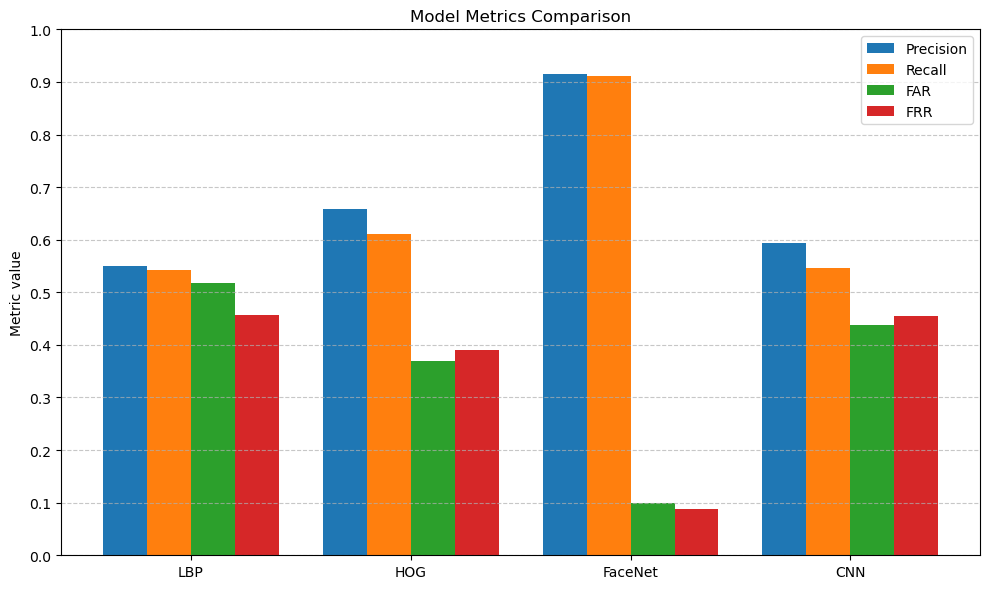

In [60]:
models = results["Model"]
precision = results["Precision"]
recall = results["Recall"]
far = results["FAR"]
frr = results["FRR"]

x = np.arange(len(models))
width = 0.2

plt.figure(figsize=(10, 6))
plt.bar(x - 1.5*width, precision, width, label='Precision')
plt.bar(x - 0.5*width, recall,    width, label='Recall')
plt.bar(x + 0.5*width, far,       width, label='FAR')
plt.bar(x + 1.5*width, frr,       width, label='FRR')

plt.xticks(x, models)
plt.ylabel("Metric value")
plt.title("Model Metrics Comparison")
plt.legend()
plt.yticks(np.arange(0, 1.1, 0.1))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig("prediction_results.svg", format='svg')
plt.show()

## Performance (time) comparison

In [21]:
def measure_prediction_time(model_path, X_test, n_runs=3):
    """
    Function measure model prediction time
    Args:
         model_path (str): Path to saved model.
         X_test (array): Test data.
         n_runs (int): Number of runs to average the results.
    Returns:
        float: Average model prediction time.
    """
    model = joblib.load(model_path)

    times = []
    for _ in range(n_runs):
        start = time.perf_counter()
        model.predict(X_test)
        end = time.perf_counter()
        times.append(end - start)

    avg_time = sum(times) / n_runs
    return avg_time

In [ ]:
avg_time_lbp = measure_prediction_time("C:/Users/marts/Downloads/SVC_lbp.pkl", X_test)
avg_time_hog = measure_prediction_time("C:/Users/marts/Downloads/SVC_hog.pkl", X_test)
avg_time_fn = measure_prediction_time("C:/Users/marts/Downloads/SVC_facenet.pkl", X_test)
avg_time_cnn = measure_prediction_time("C:/Users/marts/Downloads/SVC_cnn.pkl", X_test)

In [25]:
avg_times = [avg_time_lbp, avg_time_hog, avg_time_fn, avg_time_cnn]
models = ["LBP", "HOG", "FaceNet", "CNN"]

for model, avg_time in zip(models, avg_times):
    print(f"Model: {model}")
    print(f"Avg time of prediction on test dataset: {avg_time:.6f} s")
    print("-" * 30)

Model: LBP
Avg time of prediction on test dataset: 7.969909 s
------------------------------
Model: HOG
Avg time of prediction on test dataset: 17.241073 s
------------------------------
Model: FaceNet
Avg time of prediction on test dataset: 55.824049 s
------------------------------
Model: CNN
Avg time of prediction on test dataset: 64.554410 s
------------------------------


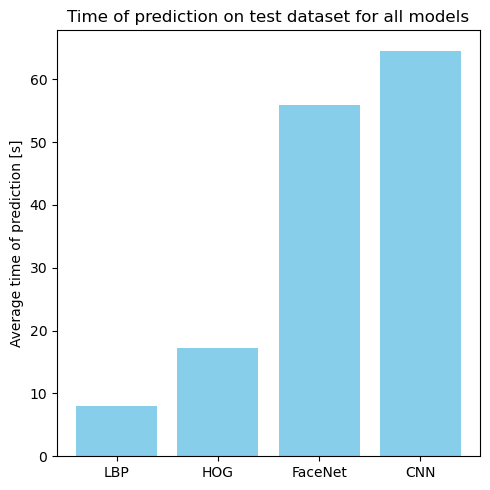

In [54]:
plt.figure(figsize=(5, 5))
plt.bar(models, avg_times, color='skyblue')
plt.ylabel("Average time of prediction [s]")
plt.title("Time of prediction on test dataset for all models")
plt.tight_layout()
plt.savefig("prediction_times.svg", format='svg')
plt.show()

## Additional tests

1. brightness distortion
2. contrast distortion
3. saturation change
4. rotation
5. blur (Gaussian)
6. color distortion

In [26]:
def apply_transformations(img_pil, transform_name):
    """
    Function applies a various transformations to PIL image:
        - brightness up and down,
        - contrast up and down,
        - saturation up and down,
        - rotate 15 and -15 degrees,
        - gaussian blur,
        - color shift.
    Args:
        img_pil (PIL Image): PIL Image to be transformed.
        transform_name (str): Name of transformation to apply.
    Returns:
        img_pil (PIL Image): PIL Image after transformation.
    """
    if transform_name == "brightness_down":
        img_pil = ImageEnhance.Brightness(img_pil).enhance(0.5)
    elif transform_name == "brightness_up":
        img_pil = ImageEnhance.Brightness(img_pil).enhance(1.5)
    elif transform_name == "contrast_down":
        img_pil = ImageEnhance.Contrast(img_pil).enhance(0.5)
    elif transform_name == "contrast_up":
        img_pil = ImageEnhance.Contrast(img_pil).enhance(1.5)
    elif transform_name == "saturation_down":
        img_pil = ImageEnhance.Color(img_pil).enhance(0.5)
    elif transform_name == "saturation_up":
        img_pil = ImageEnhance.Color(img_pil).enhance(1.5)
    elif transform_name == "rotate_15":
        img_pil = img_pil.rotate(15)
    elif transform_name == "rotate_-15":
        img_pil = img_pil.rotate(-15)
    elif transform_name == "gaussian_blur":
        img_np = cv2.GaussianBlur(np.array(img_pil), (7, 7), 1.5)
        return img_np
    elif transform_name == "color_shift":
        img_np = np.array(img_pil).astype(np.int16)
        img_np[..., 0] = np.clip(img_np[..., 0] + 20, 0, 255)  # Red
        img_np[..., 1] = np.clip(img_np[..., 1] - 10, 0, 255)  # Green
        return img_np.astype(np.uint8)

    return np.array(img_pil)

In [27]:
def test_model_on_perturbations(model_path, X_test, y_test):
    """
    Function performs model predictions on test dataset with applied transformations.
    Args:
        model_path (str): Path to saved model.
        X_test (array): Test data.
        y_test (array): Test labels.
    Returns:
        perturbation results (list): List of perturbation results.
    """
    perturbations = [
    "original",
    "brightness_down",
    "brightness_up",
    "contrast_down",
    "contrast_up",
    "saturation_down",
    "saturation_up",
    "rotate_15",
    "rotate_-15",
    "gaussian_blur",
    "color_shift"
    ]

    perturbation_results = []

    for perturb in perturbations:
        if perturb == "original":
            x_mod = X_test
        else:
            x_mod = np.array([apply_transformations(img, perturb) for img in X_test])

        # metrics
        far, frr, precision, recall = evaluate_model(model_path, x_mod, y_test)

        perturbation_results.append({
            "perturbation": perturb,
            "FAR": round(far, 4),
            "FRR": round(frr, 4),
            "precision": round(precision, 4),
            "recall": round(recall, 4)
        })

    return perturbation_results

In [28]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=UserWarning)

    results_lpb = test_model_on_perturbations("C:/Users/marts/Downloads/SVC_lbp.pkl", X_test, y_test)

In [29]:
results_hog = test_model_on_perturbations("C:/Users/marts/Downloads/SVC_hog.pkl", X_test, y_test)

In [30]:
results_fn = test_model_on_perturbations("C:/Users/marts/Downloads/SVC_facenet.pkl", X_test, y_test)

In [31]:
results_cnn = test_model_on_perturbations("C:/Users/marts/Downloads/SVC_cnn.pkl", X_test, y_test)

In [33]:
results = [results_lpb, results_hog, results_fn, results_cnn]
models = ["LBP", "HOG", "FaceNet", "CNN"]

for result, model in zip(results, models):
    print("Model: ", model)
    df = pd.DataFrame(result)
    print(df.to_string(index=False))

Model:  LBP
   perturbation    FAR    FRR  precision  recall
       original 0.5172 0.4572     0.5509  0.5428
brightness_down 0.2690 0.6991     0.5667  0.3009
  brightness_up 0.3552 0.6106     0.5617  0.3894
  contrast_down 0.3552 0.5959     0.5708  0.4041
    contrast_up 0.3759 0.6165     0.5439  0.3835
saturation_down 0.5207 0.4454     0.5546  0.5546
  saturation_up 0.4862 0.4513     0.5688  0.5487
      rotate_15 0.0069 0.9823     0.7500  0.0177
     rotate_-15 0.0069 0.9794     0.7778  0.0206
  gaussian_blur 0.7724 0.2094     0.5447  0.7906
    color_shift 0.4828 0.4277     0.5808  0.5723
Model:  HOG
   perturbation    FAR    FRR  precision  recall
       original 0.3690 0.3894     0.6592  0.6106
brightness_down 0.4069 0.3658     0.6456  0.6342
  brightness_up 0.3759 0.3864     0.6562  0.6136
  contrast_down 0.4034 0.3658     0.6476  0.6342
    contrast_up 0.3828 0.4071     0.6442  0.5929
saturation_down 0.3586 0.3894     0.6656  0.6106
  saturation_up 0.3793 0.4159     0.6429  0.5

In [57]:
results = [results_lpb, results_hog, results_fn, results_cnn]
models = ["LBP", "HOG", "FaceNet", "CNN"]
metrics = ["precision", "recall", "FAR", "FRR"]

metric_dicts = {metric: {} for metric in metrics}

for result, model_name in zip(results, models):
    df = pd.DataFrame(result)
    for _, row in df.iterrows():
        perturbation = row["perturbation"]
        for metric in metrics:
            if perturbation not in metric_dicts[metric]:
                metric_dicts[metric][perturbation] = {}
            metric_dicts[metric][perturbation][model_name] = row[metric]

for metric in metrics:
    df_metric = pd.DataFrame(metric_dicts[metric]).T
    df_metric.index.name = "Perturbation"

    plt.figure(figsize=(10, 6))
    sns.heatmap(df_metric, annot=True, fmt=".2f", cmap="Blues", cbar_kws={'label': metric.capitalize()})
    plt.title(f"{metric.capitalize()} – the impact of all disruptions on models")
    plt.xlabel("Model")
    plt.ylabel("Disruption")
    plt.tight_layout()

    filename = f"heatmap_{metric}.svg"
    plt.savefig(filename, format="svg")
    plt.close()
